In [8]:
import pandas as pd
import pandas as pd
from pathlib import Path
from utils.distfit import *
from utils.clustering import *
from utils.scenario_gen import *
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm
import scipy.spatial.distance as distance

import sys

In [9]:
datapath = Path(Path().cwd().parents[3]) / 'DR_IJmuiden' / 'data'
scenpath = datapath / 'forecast data' / 'Scenarios'
tpepath = datapath / 'forecast data' / 'TPE Search results'

In [10]:
def get_scenariopath(name, method, n_clusters, n_wb_clusters=None):
    if name == 'discharge':
        return scenpath / f'{name}_{method}_{n_wb_clusters}_{n_clusters}.pkl'
    else:
        return scenpath / f'{name}_{method}_{n_clusters}.pkl'
    # else:
    #     raise ValueError(f'Invalid name: {name}')

In [11]:
variable = 'WL'
method = 'energy'
n_clusters = 10
n_wb_clusters = 10

data = pd.read_pickle(get_scenariopath(variable, method, n_clusters, n_wb_clusters))


<AxesSubplot: >

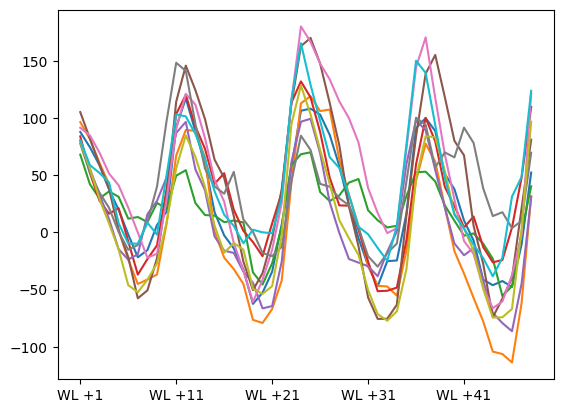

In [12]:
data.iloc[0:n_clusters,:-1].T.plot(legend=False)

In [13]:
if variable == 'WL':
    realpath = tpepath / 'CQRDNN_WL_IJmuiden'

    realdata = pd.read_csv(realpath / 'Forecasts' / 'y_test.csv', index_col=0, parse_dates=True)
else:
    realdata = None

In [14]:
data.index

MultiIndex([('2019-01-01 00:00:00+00:00', 0),
            ('2019-01-01 00:00:00+00:00', 1),
            ('2019-01-01 00:00:00+00:00', 2),
            ('2019-01-01 00:00:00+00:00', 3),
            ('2019-01-01 00:00:00+00:00', 4),
            ('2019-01-01 00:00:00+00:00', 5),
            ('2019-01-01 00:00:00+00:00', 6),
            ('2019-01-01 00:00:00+00:00', 7),
            ('2019-01-01 00:00:00+00:00', 8),
            ('2019-01-01 00:00:00+00:00', 9),
            ...
            ('2021-01-30 21:00:00+00:00', 0),
            ('2021-01-30 21:00:00+00:00', 1),
            ('2021-01-30 21:00:00+00:00', 2),
            ('2021-01-30 21:00:00+00:00', 3),
            ('2021-01-30 21:00:00+00:00', 4),
            ('2021-01-30 21:00:00+00:00', 5),
            ('2021-01-30 21:00:00+00:00', 6),
            ('2021-01-30 21:00:00+00:00', 7),
            ('2021-01-30 21:00:00+00:00', 8),
            ('2021-01-30 21:00:00+00:00', 9)],
           names=['date', 'scenario'], length=182620)

In [15]:
date = data.index[11*n_clusters][0]
date

Timestamp('2019-01-01 11:00:00+0000', tz='UTC')

In [16]:
idx = pd.IndexSlice
scenarios = data.loc[idx[date, :]]
scenarios

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
scenario,,,,,,,,,,,,,,,,,,,,,
0,113.87,85.45,52.39,23.06,12.95,19.84,19.84,-3.39,-36.18,-32.30,...,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45,0.099258
1,146.38,130.05,90.89,52.99,34.70,21.80,-6.14,-15.88,-3.65,28.41,...,65.88,18.10,-9.61,-32.15,-39.64,-63.68,-69.54,-65.17,-46.62,0.090622
2,133.37,108.99,58.53,16.39,-2.89,-7.24,-14.18,-19.22,-31.94,-17.84,...,52.55,18.20,13.15,14.68,13.82,25.39,46.68,46.35,36.64,0.093425
3,127.05,112.38,85.71,50.83,32.81,21.80,4.71,3.22,-6.63,-7.83,...,71.21,74.33,62.84,44.62,-4.53,-42.18,-62.78,-86.96,-74.35,0.108426
4,135.06,111.87,68.91,36.13,22.39,16.96,-8.82,-41.16,-51.81,-39.16,...,62.17,23.13,0.84,-11.30,-1.28,-41.77,-74.12,-62.67,-73.51,0.073410
5,121.94,102.71,69.20,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39,0.147201
6,136.73,111.74,76.13,39.64,30.17,31.73,28.53,-4.45,10.68,26.17,...,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12,0.089321
7,113.19,89.57,66.81,39.25,34.21,30.28,32.35,23.99,13.78,14.44,...,111.12,86.45,77.20,62.16,32.76,3.68,-12.19,-26.85,-3.67,0.095207
8,149.76,124.31,79.26,33.35,-0.79,-24.86,-29.91,-37.80,-46.45,-25.02,...,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35,0.122475


In [17]:
class ColorList(object):
    def __init__(self, colorlist=[f'C{i}' for i in range(10)], linestyles=['-', ':', '--', '-.']):
        self.colorlist = colorlist
        self.linestyles = linestyles
        self.combinations = list(itertools.product(self.linestyles, self.colorlist))

In [18]:
from typing import Any


class TreeNode(object):
    """
    Tree node class to construct the final tree.
    """
    def __init__(self, index, parent_id=None, children=None, scenario_ids=None, family=None, edge_values=None, domain=None, weight=1, leaf=False):
        self.index = index
        self.parent_id = parent_id

        self.children = children
        self.edge_values = edge_values
        self.domain = domain
        self.scenario_ids = scenario_ids
        self.family = family
        self.weight = weight
        self.is_leaf = leaf

        if self.children is None:
            self.children = []
        if self.edge_values is None:
            self.edge_values = []
        if self.domain is None:
            self.domain = []
        if self.scenario_ids is None:
            self.scenario_ids = []
        if self.family is None:
            self.family = []

    def __getitem__(self, key):
        return self.children[key]
    
    def __iter__(self):
        return iter(self.children)

    def __repr__(self):
        return self._repr_helper(0)

    def _repr_helper(self, indent):
        result = " " * indent
        result += f"Node: {self.index}, Scenarios: {self.scenario_ids}, Weight: {self.weight}, Domain: {self.domain}\n"

        for child in self.children:
            result += child._repr_helper(indent + 4)

        return result
    
    def get_n_timesteps(self):
        return len(np.array(self.get_domains()).flatten())
    
    def get_domains(self, domains=None):
        if domains==None:
            domains = self.domain.copy()
        for child in self.children:
            domains.extend(child.domain)
            child.get_domains(domains)
        return domains
    
    def get_nodes(self):
        # Map the nodes in a dictionary for easy access
        # Start with node 0, and recursively add all children while keeping track of the node index
        nodes = {0: self}
        self._get_nodes_helper(nodes, 0)
        return nodes
    
    def _get_nodes_helper(self, nodes, index):
        for child in self.children:
            nodes[index+1] = child
            child._get_nodes_helper(nodes, index+1)
    
    def get_edges(self, node_dict, edges=None):
        # Map the edges in a list of tuples for easy access
        # Start with node 0, and recursively add all children while keeping track of the node index
        # The node numberings are the same as the dictionary from get_nodes
        if edges is None:
            edges = []
        
        parent_key = [k for k in node_dict.keys() if node_dict[k] == self][0]
        for child in self.children:
            child_key = [k for k in node_dict.keys() if node_dict[k] == child][0]
            edges.append((parent_key, child_key))
            child.get_edges(node_dict, edges)
        return edges
    
    def plot_tree(self, parent=None, ax=None, title=None, parent_color=None, parent_linestyle=None, colorlist=None, return_axes=False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 2))

        if title is not None:
            ax.set_title(title)

        if colorlist is None:
            colorlist = ColorList()
        
        if (parent_color is None) and (parent_linestyle is None):
            parent_color = colorlist.combinations[0][1]
            parent_linestyle = colorlist.combinations[0][0]
            colorlist.combinations = colorlist.combinations[1:]
        elif (parent_color is None) or (parent_linestyle is None):
            raise ValueError("Both parent_color and parent_linestyle should be None or neither of them.")

        if parent is None:
            parent = self
            
            # Plot first node
            ax.step(parent.domain, self.edge_values, linestyle=parent_linestyle, color=parent_color, where='post')
        
        # Plot edges to children
        for i, child in enumerate(parent.children):
            if i == 0:
                child_color = parent_color
                child_linestyle = parent_linestyle
            else:
                child_color = colorlist.combinations[0][1]
                child_linestyle = colorlist.combinations[0][0]
                colorlist.combinations = colorlist.combinations[1:]
            
            # Add these to the plot to prevent gaps
            domain = [parent.domain[-1]] + child.domain
            edge_values = np.concatenate((np.array([parent.edge_values[-1]]), child.edge_values))
            
            ax.step(domain, edge_values, linestyle=child_linestyle, color=child_color, where='post')
            
            if not child.is_leaf:
                # Recursively plot child nodes
                self.plot_tree(parent=child, ax=ax, parent_color=child_color, parent_linestyle=child_linestyle, colorlist=colorlist)
        
        ax.set_xlabel("Hours")
        ax.set_ylabel("Values")
        ax.set_xlim(0, 48)
        ax.set_xticks([0, 12, 24, 36, 48])

        if return_axes:
            return fig, ax
        
    def plot_structure(self, parent=None, ax=None, title=None, colorlist=None, return_axes=False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        if title is not None:
            ax.set_title(title)

        if colorlist is None:
            colorlist = ["blue", "green", "red", "orange", "purple", "brown"]

        if parent is None:
            parent = self

        for i, child in enumerate(parent.children):
            if parent == self:
                x = [i + 0.5]
            else:
                x = [parent.index + 0.5, child.index + 0.5]

            y = [child.get_n_timesteps(), child.get_n_timesteps()]
            ax.plot(x, y, color=colorlist[child.index % len(colorlist)], linewidth=2)

            if not child.is_leaf:
                # Recursively plot child nodes
                self.plot_tree(parent=child, ax=ax, colorlist=colorlist)

        ax.set_xlabel("Node Index")
        ax.set_ylabel("Number of Timesteps")
        ax.set_xticks(range(len(self.children) + 1))
        ax.set_xlim(0, len(self.children))
        ax.set_ylim(0, self.get_n_timesteps() + 1)

        if return_axes:
            return fig, ax

    
        


    

In [19]:
class TreeClusterer():
    """Class to cluster a scenario fan to a tree structure."""

    def __init__(self, scenario_df, method='energy', p=1, node_locations=None, node_sizes=None, verbose=True):
        self.scenario_df = scenario_df.iloc[:, :-1]
        self.weights = scenario_df.iloc[:, -1].values

        self.p = p
        self.x=self.scenario_df.values
        
        self.method = method
        self.node_locations = node_locations if node_locations else []
        self.node_sizes = node_sizes if node_sizes else []
        self.verbose = verbose

    def get_energy_score_weights(self, cluster):
        """
        Get the energy score for a cluster of scenarios.
        """
        
        A_z = np.power(np.array(np.asmatrix(distance.cdist(cluster, cluster, metric='euclidean'))), self.p)
        b = np.power(np.array(np.asmatrix(distance.cdist(cluster, self.x, metric='euclidean'))), self.p)
        b_z = 2*np.dot(b, self.weights)
        
        x0 = np.ones(len(cluster))/len(cluster)
        bounds = [(0, 1) for i in range(len(cluster))]
        res = minimize(fun=lambda x: np.dot(x, b_z) - np.dot(x, np.dot(A_z, x)),
                        x0=x0,
                        method='SLSQP',
                        bounds=bounds,
                        constraints={'type': 'eq', 'fun': lambda x: np.sum(x)-1})
        x_z = res.x
        obj_val = np.power(res.fun, 1/self.p)
        return [obj_val, x_z]

    
    def get_node_scenarios(self, column):
        # Get the unique values of the node
        unique_values = self.scenario_slice.iloc[:, column].dropna()
        
        # Get the indices of the scenarios per value
        indices = [self.scenario_tree.index[self.scenario_tree.iloc[:, column] == value].tolist() for value in unique_values]
        return indices
    
    def get_children_(self, column, parent):
        # Get the indices of non-NaN scenarios that are possible for this node
        unique_values = self.scenario_slice.iloc[:, column].dropna()
        
        # Get the indices of the possible children (= non-nan scenario at node)
        scenario_options = sum([self.scenario_slice.index[self.scenario_slice.iloc[:, column] == value].tolist() for value in unique_values], [])
        
        # Get the indices of the scenarios that need to be added to a child
        scenarios_to_merge = self.scenario_slice.index[self.scenario_slice.iloc[:, column].isna()].tolist()

        # # Check if the child scenario is completely NaN
        # for id_ in parent.scenario_ids:
        #     if self.scenario_slice.iloc[id_, :].isna().all():
        #         parent.scenario_ids.remove(id_)
                
        # Get the scenario indices in the parent node
        parent_scenarios = parent.scenario_ids

        # Filter the possible children to only include scenarios that are in the parent node
        scenario_options = [child for child in scenario_options if child in parent_scenarios]
        scenarios_to_merge = [child for child in scenarios_to_merge if child in parent_scenarios]
        
        return (scenario_options, scenarios_to_merge)
    
    def get_leaf_node(self, scenario_id, index=0, parent_id=None, weight=1):
        # Get the leaf node of the scenario
        prevcol = self.node_locations[-1]
        return TreeNode(
            index=index,
            domain=[c for c in range(prevcol, len(self.scenario_slice.columns))],
            family=None,
            scenario_ids=[scenario_id],
            edge_values=self.scenario_slice.iloc[scenario_id, prevcol:].values.flatten(),
            weight=weight,
            parent_id=parent_id,
            leaf=True
        )

    def generate_nodes(self, parent=None, level=0):
        if parent is None:
            # Make the root node with domain loc[0] - loc[1] (0, 1, 2, 3)
            self.scenario_tree_df = self.scenario_slice.copy().dropna(axis=0, how='all')
            parent = TreeNode(
                index=0, 
                domain=[c for c in range(self.node_locations[0], self.node_locations[1]+1)], #[c for c in self.scenario_tree_df.index],#
                family=self.scenario_slice.index.tolist(), 
                scenario_ids=self.scenario_slice.index.tolist(),
                edge_values=self.scenario_slice.iloc[:, self.node_locations[0]:self.node_locations[1]+1].dropna().values.flatten()
                )
            
            # Add the root node data to the DataFrame
            self.scenario_tree_df.iloc[:, self.node_locations[0]:self.node_locations[1]+1] = np.concatenate([parent.edge_values for _ in self.scenario_tree_df.index]).reshape(len(self.scenario_tree_df.index), -1)
            level += 1
        
        # Check if we are in a leaf node
        if level == len(self.node_locations)-1:
            # Add the leaves to the parent
            weights = [self.weights[i] for i in parent.scenario_ids]
            for i, scenario_id in enumerate(parent.scenario_ids):
                parent.children.append(self.get_leaf_node(
                    scenario_id=scenario_id, 
                    index=i,
                    parent_id=parent.index,
                    weight=np.round(weights[i]/sum(weights), decimals=2)
                    ))
                edge_values = parent.children[-1].edge_values
                self.scenario_tree_df.iloc[scenario_id, self.node_locations[-1]:] = edge_values
            return parent
        
        # Now move up a level every time, starting at 1, with domain starting at loc[1]+1 end at loc[2] (4, 5, 6, 7, 8)
        # Get the end column of the node
        col = self.node_locations[level + 1]  # col[2] (8) At column 'col' is the last columne where n_scenarios = n_splits[col]
        prev_col = self.node_locations[level] + 1 #  col[1] (4)
        
        # Get the indices of the scenarios grouped per unique value
        child_scenario_indices, children_to_merge = self.get_children_(col, parent)
        
        # Group the children based on the Euclidean distance between the edge values
        child_groups = [[i] for i in child_scenario_indices]

        for i, child_to_merge in enumerate(children_to_merge):
            # Original (removed) edge values of the child
            og_edge_values = self.scenario_df.iloc[child_to_merge, prev_col:col+1].values.flatten()
            # print(og_edge_values)

            # Calculate the euclidean distance between the edge values and the possible nodes
            distances = [distance.euclidean(og_edge_values, self.scenario_slice.iloc[index, prev_col:col+1].values.flatten()) for index in child_scenario_indices]

            # Get the index of the closest node
            scen_nr = np.argmin(distances)
            closest_index = child_scenario_indices[scen_nr]

            # Add the scenario to the closest node
            child_groups[scen_nr].append(child_to_merge)

            # Get the edge values of the closest node
            edge_values = self.scenario_slice.iloc[closest_index, prev_col:col+1].values.flatten()

            # Fill the scenario tree dataframe
            # print(child_to_merge, prev_col, col, edge_values)
            # print(self.scenario_tree_df.loc[child_to_merge])
            self.scenario_tree_df.iloc[child_to_merge, prev_col:col+1] = edge_values

        # Calculate the weights in the groups
        weights = [sum([self.weights[i] for i in index]) for index in child_groups]
        weights = [np.round(weight/sum(weights), decimals=2) for weight in weights]

        for i, child_group in enumerate(child_groups):
            # Add the child node to the parent
            treenode = TreeNode(
                index=i,
                parent_id=parent.index,
                domain=[c for c in range(prev_col, col+1)],
                family=child_group,
                scenario_ids=child_group,
                edge_values=self.scenario_slice.iloc[child_group[0], prev_col:col+1].values.flatten(),
                weight=weights[i]
            )
            parent.children.append(treenode)

            # Recursively generate the child nodes
            self.generate_nodes(parent=treenode, level=level+1)

        return parent
    
    def reduce_redundant_nodes(self, parent):
        # Loop through the children and check if they are identical to the parent (scenario_ids).
        # If so, remove the child and add the domain to the parents domain, and add the children to the parent.
        for child in parent.children:
            if set(child.scenario_ids) == set(parent.scenario_ids):
                parent.domain = parent.domain + child.domain
                parent.children = parent.children + child.children
                parent.children.remove(child)
                parent.edge_values = np.concatenate((parent.edge_values, child.edge_values))
                self.reduce_redundant_nodes(parent)
                if child.is_leaf:
                    parent.is_leaf = True
                break
            elif set(child.scenario_ids) == set():
                parent.children.remove(child)
                self.reduce_redundant_nodes(parent)
                if child.is_leaf:
                    parent.is_leaf = True
            else:
                self.reduce_redundant_nodes(child)
        return parent

    def generate_tree(self, node_locations=None, split_sizes=None, method='energy'):
        """
        Reduce the tree by removing nodes.
        The part untill the first mentioned node is assumed to be a single scenario.
        If the last node is not mentioned, the last split size is assumed to be the size of the whole set.

        Parameters
        ----------
        split_locations : list of int
            Locations of the splits in the tree.
        split_sizes : list of int
            Sizes of the splits in the tree.
        """    
        if node_locations is None:
            node_locations = sorted([l for l in self.node_locations], reverse=True)
        else:
            self.node_locations = sorted([l for l in node_locations])

        if split_sizes is None:
            split_sizes = sorted([s for s in self.node_sizes], reverse=True)
        else:
            self.node_sizes = sorted([s for s in split_sizes])

        if len(node_locations) == 0:
            return self.scenario_df
        if len(node_locations) != len(split_sizes):
            raise ValueError('Length of node_locations and split_sizes should be equal.')
        

        # Sort the nodes and split sizes, largest sizes should be first in iteration
        # The largest size should be with the last node
        node_locations = sorted([loc for loc in node_locations], reverse=True)
        split_sizes = sorted([s for s in split_sizes], reverse=True)

        # Make a copy of the scenario dataframe
        # This will be made NaN if the scenario is assigned to a parent, for the domain of that parent
        self.scenario_slice = self.scenario_df.copy()
        
        # Loop through the nodes and cluster the scenarios
        # CHANGED
        if self.verbose:
            iterator = tqdm(node_locations[:-1])
        else:
            iterator = node_locations[:-1]
            # iterator = node_locations

        for i, node in enumerate(iterator):
            
            # subset_size = split_sizes[1:][i] CHANGED
            subset_size = split_sizes[i]
            to_cluster = self.scenario_slice.copy().iloc[:, :node+1].dropna()
            
            # print(node, subset_size)
            if subset_size < len(to_cluster):
                clusterer = ReduceForward(x=to_cluster.values, cdn=subset_size, dist=method, verbose=False)
                clusterer.reduce_forward()
                
                clustered_scen_ids = self.scenario_slice.iloc[:, :node+1].dropna().index[clusterer.tracker[subset_size-1]['scenario_set']]
                children_to_merge = [scen_id for scen_id in to_cluster.index.to_list() if (scen_id not in clustered_scen_ids)]
                
                for scen_id in children_to_merge:
                    self.scenario_slice.iloc[scen_id, :node+1] = np.nan
                
                # self.scenario_slice.iloc[children[-1], :node] = np.nan
            elif subset_size == len(to_cluster):
                continue
            else:
                raise ValueError('Subset size should be smaller than the number of possible scenarios in the node.')
            # print(self.scenario_slice)

        # Make a tree data-structure
        self.scenario_slice = self.scenario_slice.dropna(how='all')
        self.scenario_slice = self.scenario_slice.reset_index(drop=True)
        self.tree = self.generate_nodes()
        self.tree = self.reduce_redundant_nodes(self.tree)

        # Get the weights of the scenarios
        score_weights = self.get_energy_score_weights(self.scenario_tree_df.values)
        self.energy_score = score_weights[0]
        self.fitted_weights = score_weights[1]
        self.scenario_tree_df['weights'] = self.fitted_weights
        self.scenario_tree_df = self.scenario_tree_df.round(2)

    def redistribute_weights(self, parent):
        """
        Redistribute the weights of the scenarios in the tree.
        Has to be called again after a part of the scenarios is deleted.
        """
        if parent.is_leaf:
            parent.weight = 1

        children_scenario_ids = [child.scenario_ids for child in parent.children]
        children_weights = [self.fitted_weights[children_scenario_ids[i]] for i in range(len(children_scenario_ids))]

        for i, child in enumerate(parent.children):
            child.weight = children_weights[i] / np.sum(children_weights)
            self.redistribute_weights(child)
        

In [20]:
# class TreeClusterer():
#     """Class to cluster a scenario fan to a tree structure."""

#     def __init__(self, scenario_df, method='energy', p=1, node_locations=None, node_sizes=None, verbose=True):
#         self.scenario_df = scenario_df.iloc[:, :-1]
#         self.weights = scenario_df.iloc[:, -1].values

#         self.p = p
#         self.x=self.scenario_df.values
        
#         self.method = method
#         self.node_locations = node_locations if node_locations else []
#         self.node_sizes = node_sizes if node_sizes else []
#         self.verbose = verbose

#     def get_energy_score_weights(self, cluster):
#         """
#         Get the energy score for a cluster of scenarios.
#         """
        
#         A_z = np.power(np.array(np.asmatrix(distance.cdist(cluster, cluster, metric='euclidean'))), self.p)
#         b = np.power(np.array(np.asmatrix(distance.cdist(cluster, self.x, metric='euclidean'))), self.p)
#         b_z = 2*np.dot(b, self.weights)
        
#         x0 = np.ones(len(cluster))/len(cluster)
#         bounds = [(0, 1) for i in range(len(cluster))]
#         res = minimize(fun=lambda x: np.dot(x, b_z) - np.dot(x, np.dot(A_z, x)),
#                         x0=x0,
#                         method='SLSQP',
#                         bounds=bounds,
#                         constraints={'type': 'eq', 'fun': lambda x: np.sum(x)-1})
#         x_z = res.x
#         obj_val = np.power(res.fun, 1/self.p)
#         return [obj_val, x_z]

    
#     def get_node_scenarios(self, column):
#         # Get the unique values of the node
#         unique_values = self.scenario_slice.iloc[:, column].dropna()
        
#         # Get the indices of the scenarios per value
#         indices = [self.scenario_tree.index[self.scenario_tree.iloc[:, column] == value].tolist() for value in unique_values]
#         return indices
    
#     def get_children_(self, column, parent):
#         # Get the indices of non-NaN scenarios that are possible for this node
#         unique_values = self.scenario_slice.iloc[:, column].dropna()
        
#         # Get the indices of the possible children (= non-nan scenario at node)
#         scenario_options = sum([self.scenario_slice.index[self.scenario_slice.iloc[:, column] == value].tolist() for value in unique_values], [])
        
#         # Get the indices of the scenarios that need to be added to a child
#         scenarios_to_merge = self.scenario_slice.index[self.scenario_slice.iloc[:, column].isna()].tolist()

#         # # Check if the child scenario is completely NaN
#         # for id_ in parent.scenario_ids:
#         #     if self.scenario_slice.iloc[id_, :].isna().all():
#         #         parent.scenario_ids.remove(id_)
                
#         # Get the scenario indices in the parent node
#         parent_scenarios = parent.scenario_ids

#         # Filter the possible children to only include scenarios that are in the parent node
#         scenario_options = [child for child in scenario_options if child in parent_scenarios]
#         scenarios_to_merge = [child for child in scenarios_to_merge if child in parent_scenarios]
        
#         return (scenario_options, scenarios_to_merge)
    
#     def get_leaf_node(self, scenario_id, index=0, parent_id=None, weight=1):
#         # Get the leaf node of the scenario
#         prevcol = self.node_locations[-1]
#         return TreeNode(
#             index=index,
#             domain=[c for c in range(prevcol, len(self.scenario_slice.columns))],
#             family=None,
#             scenario_ids=[scenario_id],
#             edge_values=self.scenario_slice.iloc[scenario_id, prevcol:].values.flatten(),
#             weight=weight,
#             parent_id=parent_id,
#             leaf=True
#         )

#     def generate_nodes(self, parent=None, level=0):
#         if parent is None:
#             # Make the root node with domain loc[0] - loc[1] (0, 1, 2, 3)
#             self.scenario_tree_df = self.scenario_slice.copy().dropna(axis=0, how='all')
#             parent = TreeNode(
#                 index=0, 
#                 domain=[c for c in range(self.node_locations[0], self.node_locations[1]+1)], #[c for c in self.scenario_tree_df.index],#
#                 family=self.scenario_slice.index.tolist(), 
#                 scenario_ids=self.scenario_slice.index.tolist(),
#                 edge_values=self.scenario_slice.iloc[:, self.node_locations[0]:self.node_locations[1]+1].dropna().values.flatten()
#                 )
            
#             # Add the root node data to the DataFrame
#             self.scenario_tree_df.iloc[:, self.node_locations[0]:self.node_locations[1]+1] = np.concatenate([parent.edge_values for _ in self.scenario_tree_df.index]).reshape(len(self.scenario_tree_df.index), -1)
#             level += 1
        
#         # Check if we are in a leaf node
#         if level == len(self.node_locations)-1:
#             # Add the leaves to the parent
#             weights = [self.weights[i] for i in parent.scenario_ids]
#             for i, scenario_id in enumerate(parent.scenario_ids):
#                 parent.children.append(self.get_leaf_node(
#                     scenario_id=scenario_id, 
#                     index=i,
#                     parent_id=parent.index,
#                     weight=np.round(weights[i]/sum(weights), decimals=2)
#                     ))
#                 edge_values = parent.children[-1].edge_values
#                 self.scenario_tree_df.iloc[scenario_id, self.node_locations[-1]:] = edge_values
#             return parent
        
#         # Now move up a level every time, starting at 1, with domain starting at loc[1]+1 end at loc[2] (4, 5, 6, 7, 8)
#         # Get the end column of the node
#         col = self.node_locations[level + 1]  # col[2] (8) At column 'col' is the last columne where n_scenarios = n_splits[col]
#         prev_col = self.node_locations[level] + 1 #  col[1] (4)
        
#         # Get the indices of the scenarios grouped per unique value
#         child_scenario_indices, children_to_merge = self.get_children_(col, parent)
        
#         # Group the children based on the Euclidean distance between the edge values
#         child_groups = [[i] for i in child_scenario_indices]

#         for i, child_to_merge in enumerate(children_to_merge):
#             # Original (removed) edge values of the child
#             og_edge_values = self.scenario_df.iloc[child_to_merge, prev_col:col+1].values.flatten()
#             # print(og_edge_values)

#             # Calculate the euclidean distance between the edge values and the possible nodes
#             distances = [distance.euclidean(og_edge_values, self.scenario_slice.iloc[index, prev_col:col+1].values.flatten()) for index in child_scenario_indices]

#             # Get the index of the closest node
#             scen_nr = np.argmin(distances)
#             closest_index = child_scenario_indices[scen_nr]

#             # Add the scenario to the closest node
#             child_groups[scen_nr].append(child_to_merge)

#             # Get the edge values of the closest node
#             edge_values = self.scenario_slice.iloc[closest_index, prev_col:col+1].values.flatten()

#             # Fill the scenario tree dataframe
#             # print(child_to_merge, prev_col, col, edge_values)
#             # print(self.scenario_tree_df.loc[child_to_merge])
#             self.scenario_tree_df.iloc[child_to_merge, prev_col:col+1] = edge_values

#         # Calculate the weights in the groups
#         weights = [sum([self.weights[i] for i in index]) for index in child_groups]
#         weights = [np.round(weight/sum(weights), decimals=2) for weight in weights]

#         for i, child_group in enumerate(child_groups):
#             # Add the child node to the parent
#             treenode = TreeNode(
#                 index=i,
#                 parent_id=parent.index,
#                 domain=[c for c in range(prev_col, col+1)],
#                 family=child_group,
#                 scenario_ids=child_group,
#                 edge_values=self.scenario_slice.iloc[child_group[0], prev_col:col+1].values.flatten(),
#                 weight=weights[i]
#             )
#             parent.children.append(treenode)

#             # Recursively generate the child nodes
#             self.generate_nodes(parent=treenode, level=level+1)

#         return parent
    
#     def reduce_redundant_nodes(self, parent):
#         # Loop through the children and check if they are identical to the parent (scenario_ids).
#         # If so, remove the child and add the domain to the parents domain, and add the children to the parent.
#         for child in parent.children:
#             if set(child.scenario_ids) == set(parent.scenario_ids):
#                 parent.domain = parent.domain + child.domain
#                 parent.children = parent.children + child.children
#                 parent.children.remove(child)
#                 parent.edge_values = np.concatenate((parent.edge_values, child.edge_values))
#                 self.reduce_redundant_nodes(parent)
#                 if child.is_leaf:
#                     parent.is_leaf = True
#                 break
#             elif set(child.scenario_ids) == set():
#                 parent.children.remove(child)
#                 self.reduce_redundant_nodes(parent)
#                 if child.is_leaf:
#                     parent.is_leaf = True
#             else:
#                 self.reduce_redundant_nodes(child)
#         return parent

#     def generate_tree(self, node_locations=None, split_sizes=None, method='energy'):
#         """
#         Reduce the tree by removing nodes.
#         The part untill the first mentioned node is assumed to be a single scenario.
#         If the last node is not mentioned, the last split size is assumed to be the size of the whole set.

#         Parameters
#         ----------
#         split_locations : list of int
#             Locations of the splits in the tree.
#         split_sizes : list of int
#             Sizes of the splits in the tree.
#         """    
#         if node_locations is None:
#             node_locations = sorted([l for l in self.node_locations], reverse=True)
#         else:
#             self.node_locations = sorted([l for l in node_locations])

#         if split_sizes is None:
#             split_sizes = sorted([s for s in self.node_sizes], reverse=True)
#         else:
#             self.node_sizes = sorted([s for s in split_sizes])

#         if len(node_locations) == 0:
#             return self.scenario_df
#         if len(node_locations) != len(split_sizes):
#             raise ValueError('Length of node_locations and split_sizes should be equal.')
        

#         # Sort the nodes and split sizes, largest sizes should be first in iteration
#         # The largest size should be with the last node
#         node_locations = sorted([loc for loc in node_locations], reverse=True)
#         split_sizes = sorted([s for s in split_sizes], reverse=True)

#         # Make a copy of the scenario dataframe
#         # This will be made NaN if the scenario is assigned to a parent, for the domain of that parent
#         self.scenario_slice = self.scenario_df.copy()
        
#         # Loop through the nodes and cluster the scenarios
#         # CHANGED
#         if self.verbose:
#             iterator = tqdm(node_locations[:-1])
#         else:
#             iterator = node_locations[:-1]
#             # iterator = node_locations

#         for i, node in enumerate(iterator):
            
#             # subset_size = split_sizes[1:][i] CHANGED
#             subset_size = split_sizes[i]
#             to_cluster = self.scenario_slice.copy().iloc[:, :node+1].dropna()
            
#             # print(node, subset_size)
#             if subset_size < len(to_cluster):
#                 clusterer = ReduceForward(x=to_cluster.values, cdn=subset_size, dist=method, verbose=False)
#                 clusterer.reduce_forward()
                
#                 clustered_scen_ids = self.scenario_slice.iloc[:, :node+1].dropna().index[clusterer.tracker[subset_size-1]['scenario_set']]
#                 children_to_merge = [scen_id for scen_id in to_cluster.index.to_list() if (scen_id not in clustered_scen_ids)]
                
#                 for scen_id in children_to_merge:
#                     self.scenario_slice.iloc[scen_id, :node+1] = np.nan
                
#                 # self.scenario_slice.iloc[children[-1], :node] = np.nan
#             elif subset_size == len(to_cluster):
#                 continue
#             else:
#                 raise ValueError('Subset size should be smaller than the number of possible scenarios in the node.')
#             # print(self.scenario_slice)

#         # Make a tree data-structure
#         self.scenario_slice = self.scenario_slice.dropna(how='all')
#         self.scenario_slice = self.scenario_slice.reset_index(drop=True)
#         self.tree = self.generate_nodes()
#         self.tree = self.reduce_redundant_nodes(self.tree)

#         # Get the weights of the scenarios
#         score_weights = self.get_energy_score_weights(self.scenario_tree_df.values)
#         self.energy_score = score_weights[0]
#         self.fitted_weights = score_weights[1]
#         self.scenario_tree_df['weights'] = self.fitted_weights
#         self.scenario_tree_df = self.scenario_tree_df.round(2)

#     def redistribute_weights(self, parent):
#         """
#         Redistribute the weights of the scenarios in the tree.
#         Has to be called again after a part of the scenarios is deleted.
#         """
#         if parent.is_leaf:
#             parent.weight = 1

#         children_scenario_ids = [child.scenario_ids for child in parent.children]
#         children_weights = [self.fitted_weights[children_scenario_ids[i]] for i in range(len(children_scenario_ids))]

#         for i, child in enumerate(parent.children):
#             child.weight = children_weights[i] / np.sum(children_weights)
#             self.redistribute_weights(child)

# # class ScenarioTreeOptimizationProblem(Problem):
# #     def __init__(self, scenarios, n_leafs, n_splits, constrain_complexity=False, complexity_reduction_factor=0.5, n_root_scenario_steps=3):
# #         self.n_leafs = n_leafs
# #         self.scenarios = scenarios

# #         self.constrain_complexity = constrain_complexity
# #         self.complexity_reduction_factor = complexity_reduction_factor
# #         self.max_complexity = int(np.ceil(n_leafs * len(scenarios.columns) * complexity_reduction_factor))

# #         self.n_splits = n_splits

# #         # Define the bounds 
# #         # lower: min location is the hour where more than 1 scenario can occur: [n_root_scenario_steps] * n_splits -1
# #         #       + the last hour (added manually later)
# #         #       + the size of the first split [1] (added manually later)
# #         #       + the min size of the splits: [1] * n_splits
# #         #      +  the last split size: [1]
# #         xl = np.array(
# #             # [0] + [loc] * n_splits + [47] + [1, 1] + [split_size] * n_splits
# #             [n_root_scenario_steps for i in range(self.n_splits)] + [1 for i in range(self.n_splits)])

# #         # upper: max location is the second-last hour: [46] * n_splits
# #         #       + the last hour (added manually later)
# #         #       + the size of the first split [1] (added manually later) 
# #         #       + the max size of the splits: [n_leafs] * n_splits
# #         #       + the last split size: [n_leafs]
# #         xu = np.array([46 for i in range(self.n_splits)] + [self.n_leafs for i in range(self.n_splits)])

# #         # bounds: n_locs = n_splits, n_sizes = n_splits + 1

# #         n_var = len(xl)
# #         n_obj = 1
# #         n_constr = 1 if self.constrain_complexity else 0

# #         # print(f'Number of variables: {n_var}')
# #         # print(f'Number of objectives: {n_obj}')
# #         # print(xl)
        
# #         super().__init__(
# #             n_var=n_var, n_obj=n_obj, n_ieq_constr=n_constr,
# #             xl=xl, xu=xu)

# #     def format_node_split(self, node_locations, split_sizes):
# #         node_locations = np.sort(np.array(node_locations, dtype=int))
# #         split_sizes = np.sort(np.array(split_sizes, dtype=int))

# #         node_locations = np.append(node_locations, [47])
# #         split_sizes = np.append([1], split_sizes)

# #         # print('Original')
# #         # print(node_locations)
# #         # print(split_sizes)
# #         # print('-----------------')
# #         unique_node_locations = np.unique(node_locations)
# #         unique_split_sizes = np.unique(split_sizes)

# #         # print('Unique')
# #         # print(unique_node_locations)
# #         # print(unique_split_sizes)
# #         # print('-----------------')

# #         temp_node_locations = np.empty(len(unique_node_locations), dtype=int)
# #         temp_split_sizes = np.empty(len(unique_node_locations), dtype=int)
# #         # print(temp_split_sizes)
# #         for i, loc in enumerate(unique_node_locations):
# #             # Get all indices of the node locations
# #             indices = np.where(node_locations == loc)[0]
# #             # Get the splits of all nodes with the same location
# #             splits = split_sizes[indices]
# #             # Get the minimum split of all nodes with the same location
# #             temp_split_sizes[i] = np.min(splits)
# #             # Update the temp lists
# #             temp_node_locations[i] = loc

# #         unique_split_sizes = np.unique(temp_split_sizes)
        
# #         # Repeat the same process for the split sizes
# #         new_node_locations = np.empty(len(unique_split_sizes), dtype=int)
# #         new_split_sizes = np.empty(len(unique_split_sizes), dtype=int)

# #         for i, split in enumerate(unique_split_sizes):
# #             # Get all indices of the node locations
# #             indices = np.where(temp_split_sizes == split)[0]
# #             # Get the locations of all nodes with the same split size
# #             nodes = temp_node_locations[indices]
# #             # Get the maximum locations of all nodes with the same split size
# #             new_node_locations[i] = np.max(nodes)
# #             # Update the temp lists
# #             new_split_sizes[i] = split

# #         # Add the root node
# #         new_node_locations = np.append([0], new_node_locations)
# #         # new_node_locations = np.append(new_node_locations, [47])
# #         new_split_sizes = np.append([1], new_split_sizes)

# #         return sorted(list(new_node_locations)), sorted(list(new_split_sizes))
    
# #     def check_non_decreasing(self, x):
# #         """
# #         Checks whether the tree size is non-decreasing.
# #         """
# #         for i in range(len(x)-1):
# #             if x[i] >= x[i+1]:
# #                 return False
# #         return True
    
# #     def complexity_constraint(self, locs, splits):
# #         """
# #         Checks for the amount of decision variables in the tree.
# #         """
# #         if self.get_complexity(locs, splits) > self.max_complexity:
# #             return False
# #         return True
    
# #     def get_complexity(self, locs, splits):
# #         complexity = 0
# #         for i in range(len(locs)-1):
# #             complexity += splits[i+1]*(locs[i+1] - locs[i])
        
# #         # complexity += splits[-1]*(47 - locs[-1])
# #         return complexity
    
# #     def eval_tree(self, x):
# #         x = np.array(x, dtype=int)

# #         # bounds: n_locs = n_splits, n_sizes = n_splits + 1
# #         node_locations = x[:self.n_splits]
# #         split_sizes = x[self.n_splits:]
# #         # print(x)
# #         # print(node_locations)
# #         # print(split_sizes)
# #         # print('-----------------')
# #         node_locations, split_sizes = self.format_node_split(node_locations, split_sizes)
# #         # print(node_locations)
# #         # print(split_sizes)
# #         # print()

        
# #         constr = []
# #         # Add the complexity constraint to the tree optimization
# #         if self.constrain_complexity:
# #             constr = np.append(constr, self.complexity_constraint(node_locations, split_sizes))

# #         # Check if all constraints are satisfied
# #         # If not, return inf
# #         if not np.all(constr):
# #             return np.array([np.inf]), 1 - constr
        
# #         tc = TreeClusterer(self.scenarios, verbose=False)
# #         tc.generate_tree(
# #             node_locations=node_locations,
# #             split_sizes=split_sizes,
# #             method='energy'
# #         )
# #         objs = np.array([tc.energy_score])
        
# #         return objs, 1 - constr

# #     def _evaluate(self, x, out, *args, **kwargs):
# #         """
# #         Optimize the tree.
# #         """
# #         # Generate a tree
# #         # Root node is always at 0 and size always 1
# #         res = np.empty((len(x), 1+self.n_constr))

# #         def parallel_eval(i):
# #             obj, constr = self.eval_tree(x[i])
# #             return (obj, constr)
        
# #         results = Parallel(n_jobs=-1)(delayed(parallel_eval)(i) for i in range(len(x)))

# #         for i in range(len(x)):
# #             # obj, constr = self.eval_tree(x[i])
# #             res[i,0] = results[i][0] #obj
# #             res[i,1:] = results[i][1] #constr

# #         objs = res[:,0]
# #         constr = res[:,1:]
        
# #         out['F'] = objs
# #         out['G'] = constr

In [21]:
# node_locations = [3, 8, 14, 21, 21, 27, 31, 38, 39, 47]
# split_sizes = [1, 2, 2, 3, 3, 4, 8, 8, 8, 8]

# filtered_node_locations = []
# filtered_split_sizes = []

# for i in sorted(set(node_locations)):
#     splits = [split_sizes[j] for j in range(len(node_locations)) if node_locations[j] == i]
#     filtered_node_locations.append(i)
#     filtered_split_sizes.append(np.min(splits))

# node_locations = []
# split_sizes = []

# for i in sorted(set(filtered_split_sizes)):
#     nodes = [filtered_node_locations[j] for j in range(len(filtered_split_sizes)) if filtered_split_sizes[j] == i]
#     node_locations.append(np.max(nodes))
#     split_sizes.append(i)

# node_locations = [0] + node_locations
# split_sizes = [1] + split_sizes

node_locations = [0, 7, 13, 25, 45, 47]
split_sizes = [1, 1, 3, 4, 5, 5]

print(node_locations)
print(split_sizes)

tc = TreeClusterer(scenarios, verbose=False)
tc.generate_tree(
    node_locations=node_locations,
    split_sizes=split_sizes,
    method='energy'
)

[0, 7, 13, 25, 45, 47]
[1, 1, 3, 4, 5, 5]


In [22]:
tc.tree

Node: 0, Scenarios: [0, 1, 2, 3, 4], Weight: 1, Domain: [0, 1, 2, 3, 4, 5, 6, 7]
    Node: 0, Scenarios: [1, 0, 3], Weight: 0.64, Domain: [8, 9, 10, 11, 12, 13]
        Node: 0, Scenarios: [0], Weight: 0.33, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
        Node: 1, Scenarios: [1, 3], Weight: 0.67, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
            Node: 0, Scenarios: [1], Weight: 0.46, Domain: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
            Node: 1, Scenarios: [3], Weight: 0.54, Domain: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 1, Scenarios: [2], Weight: 0.2, Domain: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 2, Scenar

In [23]:
tc.scenario_tree_df#.iloc[:,:0+1]

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
0,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45,0.15
1,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39,0.26
2,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,10.68,26.17,...,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12,0.22
3,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35,0.14
4,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-34.54,-25.20,...,74.80,46.60,36.25,6.79,-8.54,-36.44,-53.69,-48.01,-29.16,0.23


In [24]:
tc.tree.edge_values

array([121.94, 102.71,  69.2 ,  27.44,  18.51,   9.26,   2.17,  -1.25])

In [25]:
node_locations

[0, 7, 13, 25, 45, 47]

In [26]:
tc.tree

Node: 0, Scenarios: [0, 1, 2, 3, 4], Weight: 1, Domain: [0, 1, 2, 3, 4, 5, 6, 7]
    Node: 0, Scenarios: [1, 0, 3], Weight: 0.64, Domain: [8, 9, 10, 11, 12, 13]
        Node: 0, Scenarios: [0], Weight: 0.33, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
        Node: 1, Scenarios: [1, 3], Weight: 0.67, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
            Node: 0, Scenarios: [1], Weight: 0.46, Domain: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
            Node: 1, Scenarios: [3], Weight: 0.54, Domain: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 1, Scenarios: [2], Weight: 0.2, Domain: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 2, Scenar

Text(0.5, 0, 'Prediction horizon (h)')

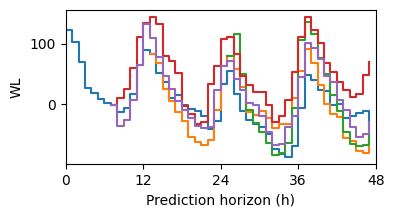

In [27]:
tc.tree.plot_tree()
plt.ylabel(variable)
plt.xlabel('Prediction horizon (h)')

In [28]:
from utils.trees import *

In [29]:
clusterer = TreeClusterer(scenarios)

In [30]:
scenarios

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
scenario,,,,,,,,,,,,,,,,,,,,,
0,113.87,85.45,52.39,23.06,12.95,19.84,19.84,-3.39,-36.18,-32.30,...,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45,0.099258
1,146.38,130.05,90.89,52.99,34.70,21.80,-6.14,-15.88,-3.65,28.41,...,65.88,18.10,-9.61,-32.15,-39.64,-63.68,-69.54,-65.17,-46.62,0.090622
2,133.37,108.99,58.53,16.39,-2.89,-7.24,-14.18,-19.22,-31.94,-17.84,...,52.55,18.20,13.15,14.68,13.82,25.39,46.68,46.35,36.64,0.093425
3,127.05,112.38,85.71,50.83,32.81,21.80,4.71,3.22,-6.63,-7.83,...,71.21,74.33,62.84,44.62,-4.53,-42.18,-62.78,-86.96,-74.35,0.108426
4,135.06,111.87,68.91,36.13,22.39,16.96,-8.82,-41.16,-51.81,-39.16,...,62.17,23.13,0.84,-11.30,-1.28,-41.77,-74.12,-62.67,-73.51,0.073410
5,121.94,102.71,69.20,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39,0.147201
6,136.73,111.74,76.13,39.64,30.17,31.73,28.53,-4.45,10.68,26.17,...,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12,0.089321
7,113.19,89.57,66.81,39.25,34.21,30.28,32.35,23.99,13.78,14.44,...,111.12,86.45,77.20,62.16,32.76,3.68,-12.19,-26.85,-3.67,0.095207
8,149.76,124.31,79.26,33.35,-0.79,-24.86,-29.91,-37.80,-46.45,-25.02,...,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35,0.122475


In [31]:
from utils.clustering import ReduceForward

In [93]:
def fix_axis(ax):
    ax.set_xlim(0, 47)
    ticks = [0, 11, 24, 36, 47]
    ax.set_xticks(ticks)
    ax.set_xticklabels([f'+{t+1}h' for t in ticks])
    ax.set_xlabel('Prediction horizon [h]')

In [ ]:
problem = ScenarioTreeOptimizationProblem(
    scenarios=scenarios.astype(float),
    n_leafs=len(scenarios.index),
    n_splits=10, # max nr of node-splitting locations
    constrain_complexity=True,
    complexity_reduction_factor=0.5,
    n_root_scenario_steps=3
)
algorithm = GA(
    pop_size=30,
    eliminate_duplicates=True,
)
res = minimize_pymoo(
    problem=problem,
    algorithm=algorithm,
    termination=('time', '00:00:15'),
    seed=1,
    verbose=False,
)
node_locations = list(res.X[:problem.n_splits])
split_sizes = list(res.X[problem.n_splits:])
node_locations, split_sizes = problem.format_node_split(node_locations, split_sizes)
tc = TreeClusterer(scenarios, verbose=False)
tc.generate_tree(
    node_locations=node_locations,
    split_sizes=split_sizes,
    method='energy'
)

In [94]:
tc.scenario_tree_df

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
0,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45,0.13
1,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,52.55,18.20,13.15,14.68,13.82,25.39,46.68,46.35,36.64,0.06
2,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,71.21,74.33,62.84,44.62,-4.53,-42.18,-62.78,-86.96,-74.35,0.12
3,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39,0.20
4,121.94,102.71,69.2,27.44,30.17,31.73,28.53,-4.45,10.68,26.17,...,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12,0.17
5,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35,0.15
6,121.94,102.71,69.2,27.44,30.17,31.73,28.53,-31.96,-34.54,-25.20,...,74.80,46.60,36.25,6.79,-8.54,-36.44,-53.69,-48.01,-29.16,0.18


100%|██████████| 10/10 [00:00<00:00, 3392.08it/s]


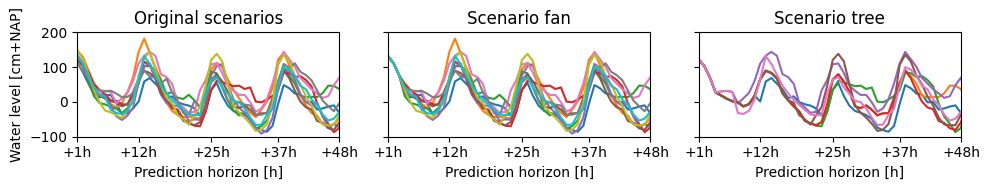

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2), sharey=True)
scenarios.iloc[:,:-1].T.plot(ax=ax[0], legend=False)
ax[0].set_title('Original scenarios')
fix_axis(ax[0])
ax[0].set_ylabel('Water level [cm+NAP]')
ax[0].set_ylim(-100, 200)

# make the scenario fan by clusterin the scenarios at the root node (3 timesteps)
to_cluster = scenarios.iloc[:,:3].values
root = ReduceForward(to_cluster, cdn=1, parallel=False)
root.reduce_forward()
rootnode = root.clusters
fan = scenarios.copy()
fan.iloc[:, :3] = rootnode.iloc[0, :3]
fan.T.plot(ax=ax[1], legend=False)
fix_axis(ax[1])
ax[1].set_title('Scenario fan')


tc.scenario_tree_df.T.plot(ax=ax[2], legend=False)
fix_axis(ax[2])
ax[2].set_title('Scenario tree')
fig.tight_layout()
fig.savefig('scenario_tree.png', dpi=300, bbox_inches='tight')
fig.savefig('scenario_tree.pdf', dpi=300, bbox_inches='tight')

In [67]:
tc.tree

Node: 0, Scenarios: [0, 1, 2, 3, 4, 5, 6], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [3, 0, 1, 2, 5], Weight: 0.77, Domain: [4, 5, 6, 7, 8, 9, 10]
        Node: 0, Scenarios: [0], Weight: 0.18, Domain: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
        Node: 1, Scenarios: [3, 1, 2, 5], Weight: 0.82, Domain: [11, 12, 13, 14, 15, 16]
            Node: 0, Scenarios: [3, 1, 2], Weight: 0.67, Domain: [17, 18, 19, 20]
                Node: 0, Scenarios: [2], Weight: 0.32, Domain: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
                Node: 1, Scenarios: [3, 1], Weight: 0.68, Domain: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
                    Node: 0, Scenarios: [1], Weight: 0.46, Domain: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
                    Node: 1, Scenarios: [3], Weig

In [53]:
root.clusters

,0,1,2,weight
0,131.69,110.73,76.3,1.0


In [ ]:
ReduceForward()

In [7]:
scenarios

NameError: name 'scenarios' is not defined

In [23]:
problem = ScenarioTreeOptimizationProblem(
    scenarios=scenarios.astype(float),
    n_leafs=len(scenarios.index),
    n_splits=10, # max nr of node-splitting locations
    constrain_complexity=True,
    complexity_reduction_factor=0.5,
    n_root_scenario_steps=3
)
algorithm = GA(
    pop_size=30,
    eliminate_duplicates=True,
)

In [24]:
res = minimize_pymoo(
    problem=problem,
    algorithm=algorithm,
    termination=('time', '00:00:15'),
    seed=1,
    verbose=False,
)

In [31]:
scenarios

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
scenario,,,,,,,,,,,,,,,,,,,,,
0,100.09,90.81,64.24,54.31,26.03,-22.43,-36.52,-23.80,6.73,27.64,...,78.38,11.90,-26.91,-45.63,-62.64,-70.85,-38.70,23.69,118.19,0.142058
1,76.30,52.18,31.14,4.37,-13.37,-28.15,-55.08,-36.83,-13.06,27.61,...,6.93,-29.91,-36.45,-40.74,-48.64,-63.77,-54.99,-33.31,11.61,0.232424
2,87.15,64.56,40.51,18.53,13.12,-11.71,-26.15,-15.10,19.36,53.95,...,45.48,81.76,72.26,14.29,14.80,-1.59,-4.33,16.33,94.80,0.251484
3,86.69,64.35,54.00,38.51,14.50,-8.93,-16.73,-22.38,-4.74,20.63,...,-3.68,-21.76,-29.51,-37.49,-56.94,-63.77,-64.22,-1.63,72.41,0.188475
4,76.91,50.12,27.55,19.74,-8.28,-32.46,-30.63,-25.19,-21.25,26.74,...,-12.45,-0.51,2.46,0.88,3.05,-5.78,16.50,107.87,129.36,0.185559


In [25]:
res.F

array([262.19855092])

In [26]:
res.G

array([0.])

In [27]:
res.cv

0.0

In [28]:
res.X.astype(int)

array([ 6,  5, 16,  3, 29, 20, 37, 10,  9, 24,  6,  4,  3,  3,  6,  7,  5,
        2,  6,  2])

In [33]:

node_locations = list(res.X[:problem.n_splits])
split_sizes = list(res.X[problem.n_splits:])

# node_locations = list((4, 5, 6, 7, 9, 27, 31))
# split_sizes = list((1, 1, 2, 3, 5, 6, 7))

# node_locations = [19, 28, 30,  9, 43, 43, 28, 19, 18, 11]
# split_sizes = [3, 3, 2, 9, 9, 6, 7, 4, 1, 5]

node_locations, split_sizes = problem.format_node_split(node_locations, split_sizes)

# Constraints dat laatste node n_leafs is
# node_locations = np.append(node_locations, 47)
# split_sizes = np.append(split_sizes, problem.n_leafs)

# node_locations = [ 0, 3, 8, 8, 14, 21, 26, 27, 31, 38, 39, 48]
# split_sizes = [1, 1, 2, 2, 2, 2, 3, 4, 8, 8, 8, 8]

print(node_locations, split_sizes)


[0, 3, 6, 10, 16, 20, 37, 47] [1, 1, 2, 3, 4, 5, 6, 7]


In [34]:
len(node_locations), len(split_sizes)

(8, 8)

In [35]:
scenarios

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48,weights
scenario,,,,,,,,,,,,,,,,,,,,,
0,113.87,85.45,52.39,23.06,12.95,19.84,19.84,-3.39,-36.18,-32.30,...,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45,0.099258
1,146.38,130.05,90.89,52.99,34.70,21.80,-6.14,-15.88,-3.65,28.41,...,65.88,18.10,-9.61,-32.15,-39.64,-63.68,-69.54,-65.17,-46.62,0.090622
2,133.37,108.99,58.53,16.39,-2.89,-7.24,-14.18,-19.22,-31.94,-17.84,...,52.55,18.20,13.15,14.68,13.82,25.39,46.68,46.35,36.64,0.093425
3,127.05,112.38,85.71,50.83,32.81,21.80,4.71,3.22,-6.63,-7.83,...,71.21,74.33,62.84,44.62,-4.53,-42.18,-62.78,-86.96,-74.35,0.108426
4,135.06,111.87,68.91,36.13,22.39,16.96,-8.82,-41.16,-51.81,-39.16,...,62.17,23.13,0.84,-11.30,-1.28,-41.77,-74.12,-62.67,-73.51,0.073410
5,121.94,102.71,69.20,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39,0.147201
6,136.73,111.74,76.13,39.64,30.17,31.73,28.53,-4.45,10.68,26.17,...,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12,0.089321
7,113.19,89.57,66.81,39.25,34.21,30.28,32.35,23.99,13.78,14.44,...,111.12,86.45,77.20,62.16,32.76,3.68,-12.19,-26.85,-3.67,0.095207
8,149.76,124.31,79.26,33.35,-0.79,-24.86,-29.91,-37.80,-46.45,-25.02,...,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35,0.122475


In [36]:
print(node_locations, split_sizes)

[0, 3, 6, 10, 16, 20, 37, 47] [1, 1, 2, 3, 4, 5, 6, 7]


In [37]:
tc = TreeClusterer(scenarios, verbose=False)
tc.generate_tree(
    node_locations=node_locations,
    split_sizes=split_sizes,
    method='energy'
)

In [38]:
len(tc.tree.get_domains()) / (len(scenarios.columns) * len(scenarios.index))

0.4857142857142857

In [39]:
# scenarios.T.plot()

In [40]:
tc.scenario_tree_df.iloc[:,:48]

,WL +1,WL +2,WL +3,WL +4,WL +5,WL +6,WL +7,WL +8,WL +9,WL +10,...,WL +39,WL +40,WL +41,WL +42,WL +43,WL +44,WL +45,WL +46,WL +47,WL +48
0,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,39.39,24.31,21.45,-1.25,0.07,-21.98,-18.54,-13.21,-9.92,-32.45
1,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,74.53,52.55,18.20,13.15,14.68,13.82,25.39,46.68,46.35,36.64
2,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,82.82,71.21,74.33,62.84,44.62,-4.53,-42.18,-62.78,-86.96,-74.35
3,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,68.25,32.25,1.17,-15.82,-21.12,-54.83,-60.22,-75.81,-80.37,-58.39
4,121.94,102.71,69.2,27.44,30.17,31.73,28.53,-4.45,10.68,26.17,...,122.81,101.04,68.72,52.87,36.58,24.35,11.66,16.46,48.10,70.12
5,121.94,102.71,69.2,27.44,18.51,9.26,2.17,-1.25,-12.78,-6.28,...,116.19,75.98,50.65,15.72,-10.36,-45.16,-64.78,-67.30,-66.63,-36.35
6,121.94,102.71,69.2,27.44,30.17,31.73,28.53,-31.96,-34.54,-25.20,...,92.70,74.80,46.60,36.25,6.79,-8.54,-36.44,-53.69,-48.01,-29.16


(0.0, 47.0)

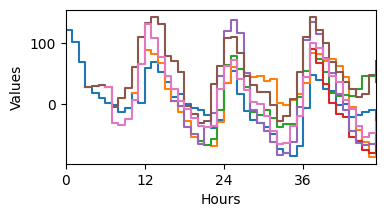

In [41]:
tc.tree.plot_tree()
plt.xlim(0,47)


In [45]:
tc.tree

Node: 0, Scenarios: [0, 1, 2, 3], Weight: 1, Domain: [0, 1, 2, 3]
    Node: 0, Scenarios: [1, 0, 2], Weight: 0.77, Domain: [4, 5]
        Node: 0, Scenarios: [1, 0], Weight: 0.6, Domain: [6, 7, 8, 9, 10, 11, 12, 13]
            Node: 0, Scenarios: [0], Weight: 0.38, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
            Node: 1, Scenarios: [1], Weight: 0.62, Domain: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
        Node: 1, Scenarios: [2], Weight: 0.4, Domain: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47]
    Node: 1, Scenarios: [3], Weight: 0.23, Domain: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,

NameError: name 'tc' is not defined

In [186]:
# fig, ax = tc.tree.plot_tree(return_axes=True)

# # if realdata is not None:
# #     ax.step(range(48), realdata.loc[date, :].iloc[:48].values.flatten(), color='black', where='post')

# ax.set_ylabel(variable)

[Text(0, 0, '1'),
 Text(5, 0, '6'),
 Text(11, 0, '12'),
 Text(17, 0, '18'),
 Text(23, 0, '24'),
 Text(29, 0, '30'),
 Text(35, 0, '36'),
 Text(41, 0, '42'),
 Text(47, 0, '48')]

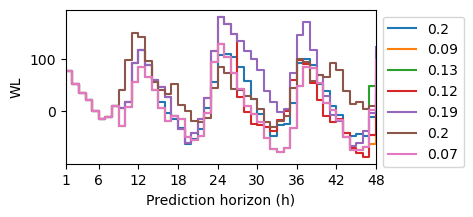

In [101]:
fig, ax = plt.subplots(figsize=(4, 2))

for i in tc.scenario_tree_df.index:
    ax.step(range(48), tc.scenario_tree_df.loc[i, :].iloc[:48].values.flatten(), where='post', label=np.round(tc.fitted_weights[i], decimals=2))

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xlim(0, 47)
ax.set_xlabel('Prediction horizon (h)')
ax.set_ylabel(variable)
ticks = [0] + [i for i in range(5, 49, 6)]
ax.set_xticks(ticks)
ax.set_xticklabels(np.array(ticks)+1)